In [1]:
import carball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline

In [2]:
num_columns = 151
class GoalPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_columns, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, game_state):
        return self.layers(game_state)

In [32]:
def get_train_test_data(proto, dataframe):
    # Only from the perspective of the blue team (we'll switch them up)
    players = dataframe.columns.levels[0]
    columns = dataframe.columns.levels[1]
    teams = proto.teams
    team_map = {}
    for i, team in enumerate(teams):
        for player in team.player_ids:
            team_map[player.id] = int(team.is_orange)
    name_team_map = {p.name: p.is_orange for p in proto.players}
    
    sorted_players = sorted([p for p in players if p not in ['ball', 'game']], key=lambda x: name_team_map[x]) + ['ball', 'game']
    
    
    goal_teams = []
    for goal in proto.game_metadata.goals:
        goal_teams.append(team_map[goal.player_id.id])
    
    # Get goal number
    goal_number = dataframe['game']['goal_number'].dropna()
    goal_team = goal_number.apply(lambda x: goal_teams[int(x)])
    #goal_frame = goal_number.apply(lambda x: goals[int(x)].frame_number)
    df = dataframe.copy()
    df['game', 'goal_team'] = goal_team.rename('goal_team')
    #df['game', 'goal_frame'] = goal_frame.rename('goal_frame')
    df = df.dropna(subset=[('game','goal_team')])
    df = df[sorted_players]
    actors = sorted_players[:-1]
    input_data = df[actors]
    if len(input_data.columns) != num_columns:
        return None, None, None, None
    
    # Set up data
    input = input_data.fillna(0).astype(float)
    output = df['game']['goal_team'].values.reshape((-1, 1))
    rand = np.random.rand(output.shape[0])
    threshold = rand < 0.8
    input_train, input_test = input[threshold].values, input[~threshold].values
    output_train, output_test = output[threshold], output[~threshold]
    
    return input_train, input_test, output_train, output_test


loss = nn.BCELoss()
def train_on_proto_df(proto, df, model):
    input_train, input_test, output_train, output_test = get_train_test_data(proto, df)
    if input_train is None:
        print('data is none')
        return
    input_tensor = torch.from_numpy(input_train).float().cuda()
    output_tensor = torch.from_numpy(output_train).float().cuda()
    print(proto.game_metadata.match_guid)
    for x in range(100):
        opt.zero_grad()
        predicted = model(input_tensor)
        loss_val = loss(predicted, output_tensor)
        loss_val.backward()
        opt.step()
        if x % 30 == 0:
            print('Loss:', loss_val)

            test_output = model(torch.from_numpy(input_test).float().cuda())
            output = test_output.cpu().detach().numpy()
            print('Accuracy', (output == output_test).sum() / output.shape[0])
    return loss_val.cpu().data.numpy(), ((output == output_test).sum() / output.shape[0])

In [33]:
from data import Calculated, Carball

data_manager = Calculated()

In [38]:
model = GoalPredictor().cuda().train()
opt = optim.Adam(model.parameters(), lr=1e-6)
epochs = 25
epoch_losses = []
accuracy = []
for epoch in range(epochs):
    epoch_loss = []
    epoch_accuracy = []
    for replay in data_manager.get_replay_list(num=200):
        df = data_manager.get_pandas(replay)
        proto = data_manager.get_proto(replay)
        if df is None or proto is None:
            continue
        try:
            los, acc = train_on_proto_df(proto, df, model)
        except Exception as e:
            print(e)
        epoch_loss.append(los)
        epoch_accuracy.append(acc)
    epoch_losses.append(epoch_loss)
    accuracy.append(epoch_accuracy)

6B28CB1611E8D98F2F542886F3F27263
Loss: tensor(11.6809, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.46219442865264354
Loss: tensor(10.4303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5002842524161455
Loss: tensor(9.9232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5287094940306992
Loss: tensor(9.3905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5474701534963047
83546D7411E8D96990653E832ADC5625
Loss: tensor(8.1100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5752508361204013
Loss: tensor(7.0352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6159420289855072
Loss: tensor(6.3338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.644927536231884
Loss: tensor(6.0950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6560758082497213
7638427E11E8D963E06E5483DF9F6172
Loss: tensor(25.1356, device='cuda:0', grad_fn=<BinaryCrossEntropyB

Loss: tensor(12.5740, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5479508196721311
AD7A753611E8D8A0396DE49E68244BC6
Loss: tensor(8.8069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6683238636363636
Loss: tensor(8.6719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6740056818181818
Loss: tensor(8.6187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6764914772727273
Loss: tensor(8.5952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6782670454545454
27CD6CA411E8D89BCAF8788D9C9B171C
Loss: tensor(0.6134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9696113074204947
Loss: tensor(0.4258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9823321554770318
Loss: tensor(0.3175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9886925795053003
Loss: tensor(0.1985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.99222614840989

'Dan'
850924EA11E8D34AF36D52BF95A970F4
Loss: tensor(14.1706, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.46504401864319006
Loss: tensor(14.1649, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4655618850336613
Loss: tensor(14.1632, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4655618850336613
Loss: tensor(14.1630, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4655618850336613
9900A64611E8D56901F275B787D06070
Loss: tensor(27.5930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.0
Loss: tensor(27.5794, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.0
Loss: tensor(27.5734, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.0
Loss: tensor(27.5699, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.0
BA93294811E8D562B03A7B8A8F6C9447
Loss: tensor(17.6078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.36235038084874865
Loss: te

E7F47EC411E8D9671D94F2A67D913D63
Loss: tensor(11.0429, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5899321266968326
Loss: tensor(11.0143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5904977375565611
Loss: tensor(10.9497, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5904977375565611
Loss: tensor(10.8380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5910633484162896
E1160F3811E8D961208CBDBB736BCBEC
Loss: tensor(0.1043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9943551888840643
Loss: tensor(0.0728, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9973947025618758
Loss: tensor(0.0336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9995657837603127
Loss: tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 1.0
FDB352F611E8D8ABF30A5A81F3D64383
Loss: tensor(15.2002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Acc

CA00795011E8D565F5C4D284BCD7229C
Loss: tensor(20.4996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.25626423690205014
Loss: tensor(20.4971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.25683371298405466
Loss: tensor(20.4971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.25683371298405466
Loss: tensor(20.4971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.25683371298405466
C709B9D811E8D89888C04BABA264708C
Loss: tensor(17.3568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.36269711799891247
Loss: tensor(17.3568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.36269711799891247
Loss: tensor(17.3568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.36269711799891247
Loss: tensor(17.3568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.36269711799891247
F261A4C011E8D6580EDE518DE6306C59
Loss: tensor(4.6683, device='cuda:0', grad_fn=<Binary

83546D7411E8D96990653E832ADC5625
Loss: tensor(24.0795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.1366906474820144
Loss: tensor(24.0490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.13779745434421695
Loss: tensor(24.0209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.13835085777531822
Loss: tensor(23.9081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.1405644714997233
7638427E11E8D963E06E5483DF9F6172
Loss: tensor(0.0307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 1.0
Loss: tensor(0.0466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 1.0
Loss: tensor(0.0429, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 1.0
Loss: tensor(0.0427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 1.0
4E2C59EC11E8D97135C37EA851CD5D38
Loss: tensor(17.0931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.37166666666666665
Loss: tensor(17.0

Loss: tensor(8.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6857243072606103
27CD6CA411E8D89BCAF8788D9C9B171C
Loss: tensor(0.6243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9680534918276374
Loss: tensor(0.2049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9888558692421991
Loss: tensor(0.1195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9955423476968797
Loss: tensor(0.0548, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9985141158989599
02268FF811E8D576F42436A9EE4D099D
Loss: tensor(22.5017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.17082429501084598
Loss: tensor(22.4443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.17136659436008678
Loss: tensor(22.3178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.17190889370932755
Loss: tensor(22.1091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.17299349

850924EA11E8D34AF36D52BF95A970F4
Loss: tensor(14.1245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.46920980926430517
Loss: tensor(14.0488, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.46975476839237057
Loss: tensor(14.0390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.470299727520436
Loss: tensor(14.0281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4708446866485014
9900A64611E8D56901F275B787D06070
Loss: tensor(27.0437, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.0027917364600781687
Loss: tensor(26.7391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.010050251256281407
Loss: tensor(25.8802, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.026242322724734785
Loss: tensor(24.3787, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.06030150753768844
BA93294811E8D562B03A7B8A8F6C9447
Loss: tensor(16.4948, device='cuda:0', grad_fn=<Bina

E7F47EC411E8D9671D94F2A67D913D63
Loss: tensor(10.7598, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5797814207650274
Loss: tensor(10.5731, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5846994535519126
Loss: tensor(10.5029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5868852459016394
Loss: tensor(10.4552, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5879781420765028
E1160F3811E8D961208CBDBB736BCBEC
Loss: tensor(0.2369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9862511457378552
Loss: tensor(0.1417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9899175068744271
Loss: tensor(0.0875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9945004582951421
Loss: tensor(0.0704, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.995417048579285
FDB352F611E8D8ABF30A5A81F3D64383
Loss: tensor(15.1209, device='cuda:0', grad_fn=<BinaryCrossEntropy

CA00795011E8D565F5C4D284BCD7229C
Loss: tensor(20.5895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2611683848797251
Loss: tensor(20.5733, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2611683848797251
Loss: tensor(20.5522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.26174112256586485
Loss: tensor(20.5410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.26174112256586485
C709B9D811E8D89888C04BABA264708C
Loss: tensor(17.3796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.37856328392246297
Loss: tensor(17.3534, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.379133409350057
Loss: tensor(17.3271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.379133409350057
Loss: tensor(17.2943, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.37970353477765106
F261A4C011E8D6580EDE518DE6306C59
Loss: tensor(4.6273, device='cuda:0', grad_fn=<BinaryCrossE

83546D7411E8D96990653E832ADC5625
Loss: tensor(23.7061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.12060301507537688
Loss: tensor(23.6509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.12171970965940815
Loss: tensor(23.6000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.12227805695142378
Loss: tensor(23.5457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.12339475153545505
7638427E11E8D963E06E5483DF9F6172
Loss: tensor(0.0070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9978880675818373
Loss: tensor(0.0076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9978880675818373
Loss: tensor(0.0051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9978880675818373
Loss: tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9978880675818373
4E2C59EC11E8D97135C37EA851CD5D38
Loss: tensor(16.9853, device='cuda:0', grad_fn=<BinaryCrossEn

Loss: tensor(8.8110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6700668308125219
27CD6CA411E8D89BCAF8788D9C9B171C
Loss: tensor(0.7094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9675036927621861
Loss: tensor(0.1509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9859675036927622
Loss: tensor(0.0284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9940915805022157
Loss: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9970457902511078
02268FF811E8D576F42436A9EE4D099D
Loss: tensor(22.0545, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.18657937806873978
Loss: tensor(21.8367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.19039825422804146
Loss: tensor(21.5319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.19639934533551553
Loss: tensor(21.4125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.20185488

850924EA11E8D34AF36D52BF95A970F4
Loss: tensor(14.1571, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.48995771670190275
Loss: tensor(14.0924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.49101479915433405
Loss: tensor(14.0536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.49207188160676535
Loss: tensor(14.0477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4931289640591966
9900A64611E8D56901F275B787D06070
Loss: tensor(26.5969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.012671594508975714
Loss: tensor(25.9759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.028511087645195353
Loss: tensor(24.2295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.061246040126715945
Loss: tensor(20.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.16261879619852165
BA93294811E8D562B03A7B8A8F6C9447
Loss: tensor(12.9381, device='cuda:0', grad_fn=<Bin

Loss: tensor(4.1743, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8516769012753898
E7F47EC411E8D9671D94F2A67D913D63
Loss: tensor(10.4177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5686059275521405
Loss: tensor(10.3195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5762897914379802
Loss: tensor(10.2454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5773874862788145
Loss: tensor(10.1715, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5784851811196488
E1160F3811E8D961208CBDBB736BCBEC
Loss: tensor(0.8168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9586741282823935
Loss: tensor(0.2435, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9849332759362893
Loss: tensor(0.1548, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9922513990529488
Loss: tensor(0.1059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.99354283254

DD123E3611E8D56856614E8DB3C35066
Loss: tensor(0.0367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9939668174962293
Loss: tensor(0.0033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.995475113122172
Loss: tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9984917043740573
Loss: tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9984917043740573
CA00795011E8D565F5C4D284BCD7229C
Loss: tensor(20.5309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.25630959057767805
Loss: tensor(20.5269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.25630959057767805
Loss: tensor(20.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.25630959057767805
Loss: tensor(20.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.25630959057767805
C709B9D811E8D89888C04BABA264708C
Loss: tensor(17.1793, device='cuda:0', grad_fn=<BinaryCrossEnt

6B28CB1611E8D98F2F542886F3F27263
Loss: tensor(22.0700, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.17834757834757833
Loss: tensor(21.9871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.1811965811965812
Loss: tensor(21.9058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.18233618233618235
Loss: tensor(21.8752, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.18404558404558405
83546D7411E8D96990653E832ADC5625
Loss: tensor(23.6133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.12367303609341826
Loss: tensor(23.5066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.12367303609341826
Loss: tensor(23.2009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.12579617834394904
Loss: tensor(22.7340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.12898089171974522
7638427E11E8D963E06E5483DF9F6172
Loss: tensor(0.2094, device='cuda:0', grad_fn=<BinaryC

Loss: tensor(11.1607, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5373073803730738
AD7A753611E8D8A0396DE49E68244BC6
Loss: tensor(9.3459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6364601769911504
Loss: tensor(9.0902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6513274336283186
Loss: tensor(8.7830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6580530973451327
Loss: tensor(8.5637, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6612389380530973
27CD6CA411E8D89BCAF8788D9C9B171C
Loss: tensor(0.6736, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9707426856714179
Loss: tensor(0.1817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9887471867966992
Loss: tensor(0.0554, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9939984996249063
Loss: tensor(0.0261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.99474868717179

3163213611E8D40A3EF378B07C977244
Loss: tensor(14.6137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4778608395629672
Loss: tensor(14.4662, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4824611845888442
Loss: tensor(14.3791, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.48533640023001723
Loss: tensor(14.3520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.48533640023001723
'Dan'
850924EA11E8D34AF36D52BF95A970F4
Loss: tensor(13.8502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.48655635987590484
Loss: tensor(13.7503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4875904860392968
Loss: tensor(13.6301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4901758014477766
Loss: tensor(13.4707, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4901758014477766
9900A64611E8D56901F275B787D06070
Loss: tensor(24.7842, device='cuda:0', grad_fn=<Bina

FAEFF95C11E8D96E6CAF59975D03616E
Loss: tensor(8.8598, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.673953488372093
Loss: tensor(7.0090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7590697674418605
Loss: tensor(4.3127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8367441860465116
Loss: tensor(3.6284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8632558139534884
E7F47EC411E8D9671D94F2A67D913D63
Loss: tensor(10.1045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5896047644829453
Loss: tensor(9.8711, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5939361126150514
Loss: tensor(9.7512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5955603681645912
Loss: tensor(9.6821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5966432051976177
E1160F3811E8D961208CBDBB736BCBEC
Loss: tensor(1.4655, device='cuda:0', grad_fn=<BinaryCrossEntropyBack

DD123E3611E8D56856614E8DB3C35066
Loss: tensor(0.0150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.997103548153512
Loss: tensor(0.0072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.999275887038378
Loss: tensor(0.0060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.999275887038378
Loss: tensor(0.0059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.999275887038378
CA00795011E8D565F5C4D284BCD7229C
Loss: tensor(20.5358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2545662100456621
Loss: tensor(20.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2545662100456621
Loss: tensor(20.5039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2545662100456621
Loss: tensor(20.4746, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2545662100456621
C709B9D811E8D89888C04BABA264708C
Loss: tensor(16.8402, device='cuda:0', grad_fn=<BinaryCrossEntropyBac

6B28CB1611E8D98F2F542886F3F27263
Loss: tensor(21.9820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.1953125
Loss: tensor(21.9084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.1953125
Loss: tensor(21.8507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.19642857142857142
Loss: tensor(21.7906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.19754464285714285
83546D7411E8D96990653E832ADC5625
Loss: tensor(23.3380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.13163716814159293
Loss: tensor(22.9134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.13219026548672566
Loss: tensor(22.1673, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.14103982300884957
Loss: tensor(21.1570, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.16039823008849557
7638427E11E8D963E06E5483DF9F6172
Loss: tensor(0.8693, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward

Loss: tensor(11.3665, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5508406725380304
AD7A753611E8D8A0396DE49E68244BC6
Loss: tensor(9.0803, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6417704011065007
Loss: tensor(8.8368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6521438450899032
Loss: tensor(8.5795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6642461964038727
Loss: tensor(8.5035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6659751037344398
27CD6CA411E8D89BCAF8788D9C9B171C
Loss: tensor(0.8810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9591690544412608
Loss: tensor(0.2512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9820916905444126
Loss: tensor(0.0916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9928366762177651
Loss: tensor(0.0665, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.99426934097421

3163213611E8D40A3EF378B07C977244
Loss: tensor(14.3078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.46440489432703
Loss: tensor(14.2320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4682981090100111
Loss: tensor(14.1779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4682981090100111
Loss: tensor(14.1414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4699666295884316
'Dan'
850924EA11E8D34AF36D52BF95A970F4
Loss: tensor(13.5583, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47413333333333335
Loss: tensor(13.3818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4816
Loss: tensor(13.3051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4842666666666667
Loss: tensor(13.1932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.48586666666666667
9900A64611E8D56901F275B787D06070
Loss: tensor(23.8770, device='cuda:0', grad_fn=<BinaryCrossEntropyB

FAEFF95C11E8D96E6CAF59975D03616E
Loss: tensor(9.9935, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6563342318059299
Loss: tensor(6.3528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7601078167115903
Loss: tensor(4.3323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8369272237196765
Loss: tensor(3.5504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8602875112309074
E7F47EC411E8D9671D94F2A67D913D63
Loss: tensor(10.0299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.588957055214724
Loss: tensor(9.8045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5923034021193531
Loss: tensor(9.6841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5967651979921919
Loss: tensor(9.6162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6012269938650306
E1160F3811E8D961208CBDBB736BCBEC
Loss: tensor(0.9912, device='cuda:0', grad_fn=<BinaryCrossEntropyBack

DD123E3611E8D56856614E8DB3C35066
Loss: tensor(0.1398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9830377794911334
Loss: tensor(0.0630, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9907478797224364
Loss: tensor(0.0160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9976869699306091
Loss: tensor(0.0073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9976869699306091
CA00795011E8D565F5C4D284BCD7229C
Loss: tensor(20.5029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.26067159931701767
Loss: tensor(20.4714, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.26067159931701767
Loss: tensor(20.4153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.26067159931701767
Loss: tensor(20.3634, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.26067159931701767
C709B9D811E8D89888C04BABA264708C
Loss: tensor(16.7309, device='cuda:0', grad_fn=<BinaryCrossEn

6B28CB1611E8D98F2F542886F3F27263
Loss: tensor(21.7986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.18342541436464088
Loss: tensor(21.6286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.1839779005524862
Loss: tensor(21.4871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.1878453038674033
Loss: tensor(21.3727, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.18729281767955802
83546D7411E8D96990653E832ADC5625
Loss: tensor(22.5450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.13055555555555556
Loss: tensor(21.7021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.14277777777777778
Loss: tensor(20.2336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.16944444444444445
Loss: tensor(18.6992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.20777777777777778
7638427E11E8D963E06E5483DF9F6172
Loss: tensor(2.2057, device='cuda:0', grad_fn=<BinaryCr

AD7A753611E8D8A0396DE49E68244BC6
Loss: tensor(8.8071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6245087531261164
Loss: tensor(8.4962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6438013576277242
Loss: tensor(8.3386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6509467667023937
Loss: tensor(8.2701, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.654876741693462
27CD6CA411E8D89BCAF8788D9C9B171C
Loss: tensor(0.6657, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9541547277936963
Loss: tensor(0.1331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9820916905444126
Loss: tensor(0.0479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9892550143266475
Loss: tensor(0.0350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9906876790830945
02268FF811E8D576F42436A9EE4D099D
Loss: tensor(20.6636, device='cuda:0', grad_fn=<BinaryCrossEntropyBack

850924EA11E8D34AF36D52BF95A970F4
Loss: tensor(13.1469, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47058823529411764
Loss: tensor(12.8775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47217806041335453
Loss: tensor(12.7108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.474827768945416
Loss: tensor(12.5631, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4732379438261791
9900A64611E8D56901F275B787D06070
Loss: tensor(22.3238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.046754675467546754
Loss: tensor(15.6510, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.21892189218921893
Loss: tensor(7.6956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5478547854785478
Loss: tensor(3.7046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7211221122112211
BA93294811E8D562B03A7B8A8F6C9447
Loss: tensor(9.5008, device='cuda:0', grad_fn=<BinaryCrossE

E7F47EC411E8D9671D94F2A67D913D63
Loss: tensor(9.8462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5940217391304348
Loss: tensor(9.6170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5978260869565217
Loss: tensor(9.4955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5983695652173913
Loss: tensor(9.4128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6
E1160F3811E8D961208CBDBB736BCBEC
Loss: tensor(1.4861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9139973672663448
Loss: tensor(0.4982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9609477841158403
Loss: tensor(0.2288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9771829749890303
Loss: tensor(0.1073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9881526985519965
FDB352F611E8D8ABF30A5A81F3D64383
Loss: tensor(14.8197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accurac

CA00795011E8D565F5C4D284BCD7229C
Loss: tensor(20.3490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2570093457943925
Loss: tensor(20.2908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2564252336448598
Loss: tensor(20.2403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2564252336448598
Loss: tensor(20.1881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2564252336448598
C709B9D811E8D89888C04BABA264708C
Loss: tensor(16.4464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.36795774647887325
Loss: tensor(16.3579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.3703051643192488
Loss: tensor(16.2739, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.36971830985915494
Loss: tensor(16.1432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.3720657276995305
F261A4C011E8D6580EDE518DE6306C59
Loss: tensor(4.7601, device='cuda:0', grad_fn=<BinaryCrossE

83546D7411E8D96990653E832ADC5625
Loss: tensor(22.1095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.12486064659977704
Loss: tensor(21.1378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.13935340022296544
Loss: tensor(19.2423, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.17558528428093645
Loss: tensor(17.6489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.22352285395763657
7638427E11E8D963E06E5483DF9F6172
Loss: tensor(2.3648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8880829015544042
Loss: tensor(0.4277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9772020725388602
Loss: tensor(0.1333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9865284974093265
Loss: tensor(0.0959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9906735751295337
4E2C59EC11E8D97135C37EA851CD5D38
Loss: tensor(15.6724, device='cuda:0', grad_fn=<BinaryCrossEn

Loss: tensor(8.0901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6554941257774707
27CD6CA411E8D89BCAF8788D9C9B171C
Loss: tensor(0.7582, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9485074626865672
Loss: tensor(0.1695, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9798507462686568
Loss: tensor(0.0773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9895522388059701
Loss: tensor(0.0436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9917910447761195
02268FF811E8D576F42436A9EE4D099D
Loss: tensor(20.3373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.19519015659955258
Loss: tensor(19.2707, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.21364653243847875
Loss: tensor(17.3662, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.24496644295302014
Loss: tensor(15.4253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.28467561

Accuracy 0.4788809654415798
Loss: tensor(12.2454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4821722435545804
Loss: tensor(12.1687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.48930334613274823
9900A64611E8D56901F275B787D06070
Loss: tensor(21.3526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.0762211486849168
Loss: tensor(13.3566, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.26301663982823403
Loss: tensor(6.1953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.583467525496511
Loss: tensor(3.0896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7552334943639292
BA93294811E8D562B03A7B8A8F6C9447
Loss: tensor(9.1355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5873893805309734
Loss: tensor(6.7893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5901548672566371
Loss: tensor(6.4332, device='cuda:0', grad_fn=<BinaryCrossEntropyBack

E7F47EC411E8D9671D94F2A67D913D63
Loss: tensor(9.6929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5882675438596491
Loss: tensor(9.4092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5964912280701754
Loss: tensor(9.2903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5970394736842105
Loss: tensor(9.2042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.600328947368421
E1160F3811E8D961208CBDBB736BCBEC
Loss: tensor(1.6555, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.902591599642538
Loss: tensor(0.4915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9584450402144772
Loss: tensor(0.2170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9749776586237712
Loss: tensor(0.1211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.982573726541555
FDB352F611E8D8ABF30A5A81F3D64383
Loss: tensor(14.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackwa

CA00795011E8D565F5C4D284BCD7229C
Loss: tensor(20.0881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.24421296296296297
Loss: tensor(19.9904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.24537037037037038
Loss: tensor(19.9213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.24537037037037038
Loss: tensor(19.8774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.24537037037037038
C709B9D811E8D89888C04BABA264708C
Loss: tensor(16.1327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.3637901861252115
Loss: tensor(15.9458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.37055837563451777
Loss: tensor(15.8653, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.3728144388042865
Loss: tensor(15.7972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.3750705019740553
F261A4C011E8D6580EDE518DE6306C59
Loss: tensor(4.7225, device='cuda:0', grad_fn=<BinaryCro

Loss: tensor(20.4785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.18208092485549132
83546D7411E8D96990653E832ADC5625
Loss: tensor(21.1569, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.15205327413984462
Loss: tensor(19.4907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.17203107658157601
Loss: tensor(16.9120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.22807991120976692
Loss: tensor(14.8819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2846836847946726
7638427E11E8D963E06E5483DF9F6172
Loss: tensor(8.0959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7623655913978494
Loss: tensor(0.9173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9559139784946237
Loss: tensor(0.2278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.989247311827957
Loss: tensor(0.1388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9924731

AD7A753611E8D8A0396DE49E68244BC6
Loss: tensor(8.4825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6381737040851356
Loss: tensor(8.0768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6611740473738414
Loss: tensor(7.9831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6659800892550635
Loss: tensor(7.8997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6690696876072777
27CD6CA411E8D89BCAF8788D9C9B171C
Loss: tensor(0.7260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9492107069320521
Loss: tensor(0.1607, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9849004804392587
Loss: tensor(0.0726, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9897048730267674
Loss: tensor(0.0424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9938229238160604
02268FF811E8D576F42436A9EE4D099D
Loss: tensor(19.9916, device='cuda:0', grad_fn=<BinaryCrossEntropyBac

850924EA11E8D34AF36D52BF95A970F4
Loss: tensor(12.4370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47297297297297297
Loss: tensor(12.1979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4604989604989605
Loss: tensor(12.0277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4656964656964657
Loss: tensor(11.8643, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47193347193347196
9900A64611E8D56901F275B787D06070
Loss: tensor(20.3938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.06760411032990805
Loss: tensor(12.3231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.290427257977285
Loss: tensor(4.9220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6138453217955652
Loss: tensor(2.4544, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7620335316387237
BA93294811E8D562B03A7B8A8F6C9447
Loss: tensor(8.5694, device='cuda:0', grad_fn=<BinaryCrossEnt

Loss: tensor(3.1172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8659070990359334
E7F47EC411E8D9671D94F2A67D913D63
Loss: tensor(9.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5857605177993528
Loss: tensor(9.2056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5960086299892126
Loss: tensor(9.0588, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5997842502696872
Loss: tensor(8.9624, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5997842502696872
E1160F3811E8D961208CBDBB736BCBEC
Loss: tensor(1.8280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8970523537175539
Loss: tensor(0.4955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9634843818741751
Loss: tensor(0.1933, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9819621645402552
Loss: tensor(0.1022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.988121425428948

DD123E3611E8D56856614E8DB3C35066
Loss: tensor(0.2337, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9754977029096478
Loss: tensor(0.0716, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9892802450229708
Loss: tensor(0.0543, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9900459418070444
Loss: tensor(0.0512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9908116385911179
CA00795011E8D565F5C4D284BCD7229C
Loss: tensor(20.0137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.26182432432432434
Loss: tensor(19.9477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.26126126126126126
Loss: tensor(19.8989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.25957207207207206
Loss: tensor(19.8553, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.26069819819819817
C709B9D811E8D89888C04BABA264708C
Loss: tensor(15.8256, device='cuda:0', grad_fn=<BinaryCrossEn

6B28CB1611E8D98F2F542886F3F27263
Loss: tensor(20.9490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.19304152637485972
Loss: tensor(20.6175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.19079685746352412
Loss: tensor(20.2999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.18462401795735128
Loss: tensor(19.8626, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.18911335578002245
83546D7411E8D96990653E832ADC5625
Loss: tensor(20.2803, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.16930638995084654
Loss: tensor(17.7401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2042599672310213
Loss: tensor(14.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2845439650464227
Loss: tensor(11.9561, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.354997269251775
7638427E11E8D963E06E5483DF9F6172
Loss: tensor(12.0692, device='cuda:0', grad_fn=<BinaryCro

Loss: tensor(10.7381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5332246229107216
Loss: tensor(10.6062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.534447615165104
Loss: tensor(10.4761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5348552792498981
AD7A753611E8D8A0396DE49E68244BC6
Loss: tensor(8.3529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6327182398864443
Loss: tensor(7.8963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6564939673527325
Loss: tensor(7.8079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6607523066004258
Loss: tensor(7.7444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6618168914123492
27CD6CA411E8D89BCAF8788D9C9B171C
Loss: tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9356254572055597
Loss: tensor(0.1110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9831748354059

3163213611E8D40A3EF378B07C977244
Loss: tensor(13.8553, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.45620842572062087
Loss: tensor(13.5088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47172949002217296
Loss: tensor(13.4035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47394678492239467
Loss: tensor(13.3387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47560975609756095
'Dan'
850924EA11E8D34AF36D52BF95A970F4
Loss: tensor(12.1550, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47835382148583644
Loss: tensor(11.8661, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47888829502939606
Loss: tensor(11.5620, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47835382148583644
Loss: tensor(11.3356, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.481560662747194
9900A64611E8D56901F275B787D06070
Loss: tensor(19.1783, device='cuda:0', grad_fn=<B

FAEFF95C11E8D96E6CAF59975D03616E
Loss: tensor(8.5769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6717625899280576
Loss: tensor(4.6344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8044064748201439
Loss: tensor(3.3127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8471223021582733
Loss: tensor(3.1073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8642086330935251
E7F47EC411E8D9671D94F2A67D913D63
Loss: tensor(9.2834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5757900374933048
Loss: tensor(9.0088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5811462238885913
Loss: tensor(8.8574, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.584895554365292
Loss: tensor(8.7849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5859667916443492
E1160F3811E8D961208CBDBB736BCBEC
Loss: tensor(1.8049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackw

DD123E3611E8D56856614E8DB3C35066
Loss: tensor(0.2624, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9722007722007722
Loss: tensor(0.0841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.983011583011583
Loss: tensor(0.0597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9907335907335907
Loss: tensor(0.0485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9915057915057915
CA00795011E8D565F5C4D284BCD7229C
Loss: tensor(19.8833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.25447201384881707
Loss: tensor(19.7666, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2550490478938257
Loss: tensor(19.6408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.25620311598384304
Loss: tensor(19.5777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2556260819388344
C709B9D811E8D89888C04BABA264708C
Loss: tensor(15.6889, device='cuda:0', grad_fn=<BinaryCrossEntro

6B28CB1611E8D98F2F542886F3F27263
Loss: tensor(20.7953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.1812933025404157
Loss: tensor(20.2741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.18013856812933027
Loss: tensor(19.6634, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.17725173210161663
Loss: tensor(19.3206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.19110854503464203
83546D7411E8D96990653E832ADC5625
Loss: tensor(19.3021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.16139767054908485
Loss: tensor(15.9184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.21075984470327233
Loss: tensor(12.7183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.3105934553521908
Loss: tensor(9.6921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.40931780366056575
7638427E11E8D963E06E5483DF9F6172
Loss: tensor(14.7562, device='cuda:0', grad_fn=<BinaryCr

Loss: tensor(10.3298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5338842975206611
AD7A753611E8D8A0396DE49E68244BC6
Loss: tensor(8.1160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.624866785079929
Loss: tensor(7.7873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.647246891651865
Loss: tensor(7.7277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6518650088809946
Loss: tensor(7.6514, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6529307282415631
27CD6CA411E8D89BCAF8788D9C9B171C
Loss: tensor(0.8080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9509157509157509
Loss: tensor(0.1144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9860805860805861
Loss: tensor(0.0355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9926739926739927
Loss: tensor(0.0177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9934065934065934

3163213611E8D40A3EF378B07C977244
Loss: tensor(13.7510, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4524530587522714
Loss: tensor(13.2650, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4597213809812235
Loss: tensor(12.9916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.465778316172017
Loss: tensor(12.7856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4700181708055724
'Dan'
850924EA11E8D34AF36D52BF95A970F4
Loss: tensor(11.8201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.48415300546448087
Loss: tensor(11.5712, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.48743169398907105
Loss: tensor(11.3568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4890710382513661
Loss: tensor(11.2121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.49453551912568305
9900A64611E8D56901F275B787D06070
Loss: tensor(18.4920, device='cuda:0', grad_fn=<Binar

FAEFF95C11E8D96E6CAF59975D03616E
Loss: tensor(9.0361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6374773139745916
Loss: tensor(4.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.792649727767695
Loss: tensor(3.2802, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8434664246823956
Loss: tensor(3.0773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8579854809437386
E7F47EC411E8D9671D94F2A67D913D63
Loss: tensor(9.1906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5902276513048307
Loss: tensor(8.9797, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5946696279844531
Loss: tensor(8.8616, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5957801221543587
Loss: tensor(8.7816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5968906163242643
E1160F3811E8D961208CBDBB736BCBEC
Loss: tensor(1.8032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackw

DD123E3611E8D56856614E8DB3C35066
Loss: tensor(0.2365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9691497366440933
Loss: tensor(0.1003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9849510910458992
Loss: tensor(0.0795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9917231000752446
Loss: tensor(0.0690, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9917231000752446
CA00795011E8D565F5C4D284BCD7229C
Loss: tensor(19.7182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2552348613469157
Loss: tensor(19.5098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2552348613469157
Loss: tensor(19.2131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2591963780418789
Loss: tensor(18.8722, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2614601018675722
C709B9D811E8D89888C04BABA264708C
Loss: tensor(15.2150, device='cuda:0', grad_fn=<BinaryCrossEntrop

Accuracy 0.7528770442156268
Loss: tensor(6.1756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7540884312537856
Loss: tensor(6.1482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7559055118110236
6B28CB1611E8D98F2F542886F3F27263
Loss: tensor(20.7326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.19895591647331787
Loss: tensor(20.0667, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.20475638051044084
Loss: tensor(19.4359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2140371229698376
Loss: tensor(18.8617, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.22679814385150812
83546D7411E8D96990653E832ADC5625
Loss: tensor(17.8445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.17736670293797607
Loss: tensor(14.5693, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.2676822633297062
Loss: tensor(10.3263, device='cuda:0', grad_fn=<BinaryCrossEntro

81E8D08011E8D8A9C4081E9F4F5240F3
Loss: tensor(10.5414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5302175664786463
Loss: tensor(10.3989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5318291700241741
Loss: tensor(10.2730, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5346494762288477
Loss: tensor(10.1908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5374697824335214
AD7A753611E8D8A0396DE49E68244BC6
Loss: tensor(8.1519, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6318840579710145
Loss: tensor(7.7839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6572463768115943
Loss: tensor(7.6851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6630434782608695
Loss: tensor(7.6149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6648550724637681
27CD6CA411E8D89BCAF8788D9C9B171C
Loss: tensor(0.7001, device='cuda:0', grad_fn=<BinaryCrossEntropy

3163213611E8D40A3EF378B07C977244
Loss: tensor(13.3273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4542372881355932
Loss: tensor(12.9807, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47401129943502823
Loss: tensor(12.6986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4807909604519774
Loss: tensor(12.5772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4824858757062147
'Dan'
850924EA11E8D34AF36D52BF95A970F4
Loss: tensor(11.2980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5007759958613555
Loss: tensor(10.9349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5043973098810139
Loss: tensor(10.7304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5090532850491464
Loss: tensor(10.6080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5147439213657528
9900A64611E8D56901F275B787D06070
Loss: tensor(16.6562, device='cuda:0', grad_fn=<Binary

Loss: tensor(9.9110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.44311034877072614
Loss: tensor(9.4892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.465980560320183
FAEFF95C11E8D96E6CAF59975D03616E
Loss: tensor(9.2827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6391608391608392
Loss: tensor(4.0956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7986013986013986
Loss: tensor(3.1243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8452214452214453
Loss: tensor(3.0187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8536130536130536
E7F47EC411E8D9671D94F2A67D913D63
Loss: tensor(8.9795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5936
Loss: tensor(8.7532, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6026666666666667
Loss: tensor(8.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6042666666666666
Loss: tens

0B85A4E811E8D56DD7D928A5E6D1B582
Loss: tensor(3.4280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8338582677165355
Loss: tensor(3.0492, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8574803149606299
Loss: tensor(2.9561, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8700787401574803
Loss: tensor(2.9521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8724409448818897
DD123E3611E8D56856614E8DB3C35066
Loss: tensor(0.1939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9796992481203007
Loss: tensor(0.0881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9894736842105263
Loss: tensor(0.0625, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9924812030075187
Loss: tensor(0.0485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9932330827067669
CA00795011E8D565F5C4D284BCD7229C
Loss: tensor(19.5604, device='cuda:0', grad_fn=<BinaryCrossEntropyBac

Loss: tensor(7.5610, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7206477732793523
Loss: tensor(7.4901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7191295546558705
Loss: tensor(7.4350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7140688259109311
49874DFC11E8D278396D868E68244BC6
Loss: tensor(6.2110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7330873308733087
Loss: tensor(6.1085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7373923739237392
Loss: tensor(6.0662, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7435424354243543
Loss: tensor(6.0322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7435424354243543
6B28CB1611E8D98F2F542886F3F27263
Loss: tensor(20.1804, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.1875
Loss: tensor(19.4995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.18807339449541285
Loss: t

6332E0D211E8D8AD41B47F964097B559
Loss: tensor(1.9692, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8619565217391304
Loss: tensor(0.3193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.967391304347826
Loss: tensor(0.2037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9793478260869565
Loss: tensor(0.1907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9793478260869565
81E8D08011E8D8A9C4081E9F4F5240F3
Loss: tensor(10.4710, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5304558289632917
Loss: tensor(10.3109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5320693828156515
Loss: tensor(10.1724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5304558289632917
Loss: tensor(10.0927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5316659943525616
AD7A753611E8D8A0396DE49E68244BC6
Loss: tensor(8.0242, device='cuda:0', grad_fn=<BinaryCrossEntropyB

E2F30DDA11E8D55ECF59A4B93158549E
Loss: tensor(12.4002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4165270798436628
Loss: tensor(11.4860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4148520379676159
Loss: tensor(11.0973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.42266890005583474
Loss: tensor(10.7334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4304857621440536
3163213611E8D40A3EF378B07C977244
Loss: tensor(12.7941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4200940070505288
Loss: tensor(12.3068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4606345475910693
Loss: tensor(12.1382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4600470035252644
Loss: tensor(11.9587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.46298472385428907
'Dan'
850924EA11E8D34AF36D52BF95A970F4
Loss: tensor(10.7773, device='cuda:0', grad_fn=<Binar

6D23376011E8D97D69408DA9A37BC12B
Loss: tensor(12.3724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.34942528735632183
Loss: tensor(10.4668, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4028735632183908
Loss: tensor(9.2938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4614942528735632
Loss: tensor(8.8579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.48563218390804597
FAEFF95C11E8D96E6CAF59975D03616E
Loss: tensor(9.9274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.6182648401826484
Loss: tensor(3.9477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8018264840182648
Loss: tensor(3.1273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8561643835616438
Loss: tensor(3.0413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8639269406392694
E7F47EC411E8D9671D94F2A67D913D63
Loss: tensor(8.5818, device='cuda:0', grad_fn=<BinaryCrossEntropy

0B85A4E811E8D56DD7D928A5E6D1B582
Loss: tensor(3.2466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8258381030253475
Loss: tensor(2.9692, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8528209321340965
Loss: tensor(2.9296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8618152085036794
Loss: tensor(2.9070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8650858544562551
DD123E3611E8D56856614E8DB3C35066
Loss: tensor(0.2014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9799072642967542
Loss: tensor(0.0442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9945904173106646
Loss: tensor(0.0263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9961360123647605
Loss: tensor(0.0182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9969088098918083
CA00795011E8D565F5C4D284BCD7229C
Loss: tensor(19.2537, device='cuda:0', grad_fn=<BinaryCrossEntropyBac

Loss: tensor(7.4185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.712039312039312
Loss: tensor(7.3628, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.711056511056511
Loss: tensor(7.3379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7090909090909091
49874DFC11E8D278396D868E68244BC6
Loss: tensor(6.2113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7431859479103574
Loss: tensor(6.1346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7486371895820715
Loss: tensor(6.0899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7504542701393095
Loss: tensor(6.0516, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.7492428831011508
6B28CB1611E8D98F2F542886F3F27263
Loss: tensor(20.1938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.20902090209020902
Loss: tensor(19.2322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.21232123212321

6332E0D211E8D8AD41B47F964097B559
Loss: tensor(2.2258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.8740499457111836
Loss: tensor(0.3606, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.9728555917480999
Loss: tensor(0.2448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.988056460369164
Loss: tensor(0.2195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.98914223669924
81E8D08011E8D8A9C4081E9F4F5240F3
Loss: tensor(10.4053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5245038477116242
Loss: tensor(10.2029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5261239368165249
Loss: tensor(10.0528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.528554070473876
Loss: tensor(9.9842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.5313892264074525
AD7A753611E8D8A0396DE49E68244BC6
Loss: tensor(7.9759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackw

E2F30DDA11E8D55ECF59A4B93158549E
Loss: tensor(11.8093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4315030504714365
Loss: tensor(10.5648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.44315030504714364
Loss: tensor(10.2488, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4525790349417637
Loss: tensor(10.0760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.45202440377149194
3163213611E8D40A3EF378B07C977244
Loss: tensor(12.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4229898074745187
Loss: tensor(12.0732, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.4711211778029445
Loss: tensor(11.8962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47281993204983014
Loss: tensor(11.7897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Accuracy 0.47678369195922987
'Dan'
850924EA11E8D34AF36D52BF95A970F4
Loss: tensor(10.5623, device='cuda:0', grad_fn=<Bin

Text(0.5, 1.0, 'Loss')

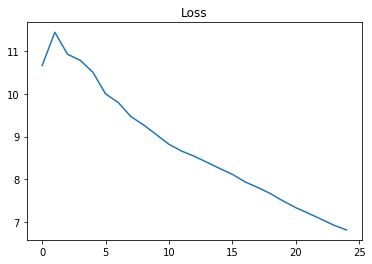

In [39]:
means = []
for l in epoch_losses:
    l = np.array(l)
    l = l[l != None]
    means.append(l.mean())

plt.plot(range(len(epoch_losses)), means)
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

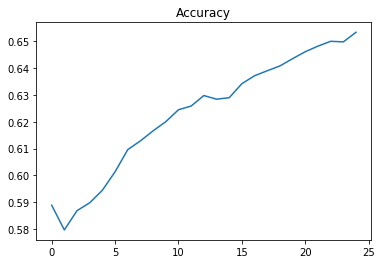

In [40]:
means = []
for l in accuracy:
    l = np.array(l)
    l = l[l != None]
    means.append(l.mean())
plt.plot(range(len(accuracy)), means)
plt.title('Accuracy')